# Vanishing / Exploding gradients

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
%matplotlib inline

## Partial derivatives

$$\frac{\delta L}{\delta W_h} \propto \sum_{1\le k\le t} \left(\prod_{t\ge i>k} \frac{\delta h_i}{\delta h_{i-1}}\right)\frac{\delta h_k}{\delta W_h}$$

$$\prod_{t\ge i>k} \frac{\delta h_i}{\delta h_{i-1}}$$

$$h_i= \sigma(W_{hh} h_{i-1} + W_{hx} x_i + b_h)$$

$$\frac{\delta h_i}{\delta h_{i-1}} = W_{hh}^T \text{diag} (\sigma'(W_{hh} h_{i-1} + W_{hx} x_i + b_h))$$


## Vanishing and exploding gradients

When the product 

$$\prod_{t\ge i > k} \frac{\partial h_i}{\partial h_{i-1}} = \prod_{t\ge i > k} W_{hh}^T \text{diag} (\sigma'(W_{hh} h_{i-1} + W_{hx} x_i + b_h))$$

approaches 0, you face vanishing gradient problems where the contribution of item $k$ in the sequence is neglected. Conversely, when the product approaches infinity you will face exploding gradients and convergence problems arise. For that product approaching either of those values, two conditions need to be met:

<ol>
<li> Derivative of the activation function is bounded by some value $\alpha$ </li>
<li> The absolute value of the largest eigenvalue of the weight matrix $W_{hh}$ is lower than $\frac{1}{\alpha}$ (sufficient condition for vanishing gradient), or greater than $\frac{1}{\alpha}$ (necessary condition for exploding gradient).</li> 
</ol>

### Activation

So let's check the first condition for the sigmoid function. Run the cell below to get an interactive plot of the sigmoid function and its derivative at different points. Feel free to change the argument values to check if the derivative is bounded or not.

In [8]:
# Data

### START CODE HERE ###
x = np.linspace(-6, 6, 100)  # try changing the range of values in the data. eg: (-100,100,1000)
### END CODE HERE ###

# Activation
# Interval [0, 1]
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

activations = sigmoid(x)

# Gradient
# Interval [0, 0.25]
def sigmoid_gradient(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Add the tangent line
def plot_func(x_tan = 0):
    plt.plot(x, activations)
    plt.title("Sigmoid Function and Gradient")
    plt.xlabel("$x$")
    plt.ylabel("sigmoid($x$)")
    plt.text(x_tan, sigmoid(x_tan), f"Gradient: {sigmoid_gradient(x_tan):.4f}")
    plt.xlim((-6,6))
    plt.ylim((-0.5,1.5))
    plt.rcParams['figure.figsize'] = [7, 5]
    y_tan = sigmoid(x_tan)  # y value
    span = 4 # line span along x axis
    data_tan = np.linspace(x_tan - span, x_tan + span)  # x values to plot
    gradient_tan = sigmoid_gradient(x_tan)     # gradient of the tangent
    tan = y_tan + gradient_tan * (data_tan - x_tan)     # y values to plot
    plt.plot(x_tan, y_tan, marker="o", color="orange", label=True)  # marker
    plt.plot(data_tan, tan, linestyle="--", color="orange")         # line
    plt.show()

interact(plot_func, x_tan = widgets.FloatSlider(value=0,
                                            min=-6,
                                            max=6,
                                            step=0.5))

interactive(children=(FloatSlider(value=0.0, description='x_tan', max=6.0, min=-6.0, step=0.5), Output()), _do…

<function __main__.plot_func(x_tan=0)>

As you checked, the derivative of the sigmoid function is bounded by $\alpha=\frac{1}{4}$. So vanishing gradient problems will arise for long-term components if the largest eigenvalue of $W_{hh}$ is lower than 4, and exploding gradient problems will happen if the largest eigenvalue is larger than 4. 

## Vanishing Gradient with Sigmoid Activation 

In [10]:
np.random.seed(12345)
t = 20
h = np.random.randn(5,t)
x = np.random.randn(5,t)

In [11]:
b_h = np.random.randn(5,1)
W_hx = np.random.randn(5,5)

In [12]:
eig = np.random.rand(5)*4 # Random eigenvalues lower than 4
Q = np.random.randn(5,5) # Random eigenvectors stacked in matrix Q
W_hh = Q@np.diag(eig)@np.linalg.inv(Q) #W_hh

In [13]:
def prod(k):
    p = 1 
    for i in range(t-1, k-2, -1):
        p *= W_hh.T@np.diag(sigmoid_gradient(W_hh@h[:,i]+ W_hx@x[:,i] + b_h))
    return p

([<matplotlib.axis.XTick at 0x11fb1e310>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20')])

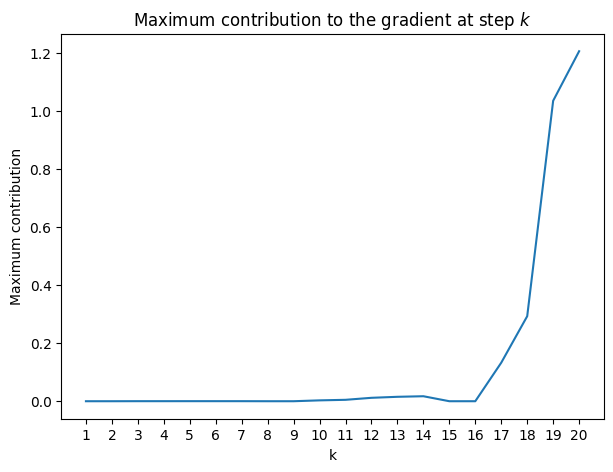

In [14]:
product = np.zeros(20)
for k in range(t):
    product[k] = np.max(prod(k+1))

plt.plot(np.array(range(t))+1, product)
plt.title("Maximum contribution to the gradient at step $k$");
plt.xlabel("k");
plt.ylabel("Maximum contribution")
plt.xticks(np.array(range(t))+1)

With the largest eigenvalue of the weight matrix $W_{hh}$ being lower than 4 --with a sigmoid activation function, the contribution of the early items in the sequence to the gradient go to zero. In practice, this will make your RNN rely only upon the most recent items in the series. 